### Generating linear models for absolute abundance calculation

In [25]:
library(data.table)
library(reshape2)
library(ggplot2)
library(ggpmisc)
library(plyr)

In [21]:
setwd("/home/zaramela/Dropbox/postdoc/metagenome_control/saliva_analysis/")

#### Loading metadata, dilutions, and synDNA frequency table

In [22]:
#Loading files (count table, metadata, synDNAs dilutions)

synDNAcounts <- read.delim("synDNA_Fwd_Rev_sam.biom.txt", h=T)
metadata <- read.delim("synDNA_metadata.csv", h=T)
metadata$Files <- gsub("synDNA.sam", "synDNA", metadata$Files)
dilutions <- read.delim("dilutions_metadata_pool.tsv")

#### Parsing the files

In [5]:
#Calculation total number of reads aligned to the synDNAs

TotalAlign <- data.frame(apply(synDNAcounts[,-1], 2, sum))
TotalAlign <- data.frame(Files = rownames(TotalAlign), TotalAlign = TotalAlign$apply.synDNAcounts....1...2..sum.)

In [7]:
#Matrix to data.frame and merging with total number of aligned reads

#synDNApools <- cbind(synDNAcounts$OTUID, synDNAcounts)
synDNApoolsM <- melt(synDNAcounts)
colnames(synDNApoolsM) <- c("SynDNAName", "Files", "Counts")
synDNApoolsMelt <- merge(synDNApoolsM, TotalAlign, by="Files")


Using OTUID as id variables



In [9]:
#Merge table with metadata
synDNAMeta <- merge(synDNApoolsMelt, metadata, by = "Files") 

#Aggregate counts from same library, but different lane (Novaseq lanes)
synDNAMetaAg <- aggregate(cbind(Counts,TotalReads,TotalAlign)~Strand+ID+SynDNAName+Pool, synDNAMeta, sum)

#Calculate CPM and percetange 
synDNAMetaAg$CPM <- (synDNAMetaAg$Counts/synDNAMetaAg$TotalReads)*1000000
synDNAMetaAg$Percentage <- (synDNAMetaAg$Counts/synDNAMetaAg$TotalReads)/100

#Log Transformation
synDNAMetaAg$CPMlog <- log10(synDNAMetaAg$CPM)
synDNAMetaAgM <- merge(synDNAMetaAg, dilutions, by = c("SynDNAName", "Pool"))
synDNAMetaAgM <- synDNAMetaAgM[-grep("J1_", synDNAMetaAgM$ID), ] ## sample with low quality and counts

#### Visualizing the serial dilution

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing non-finite values (stat_poly_eq).”
Warning message:
“Removed 8 rows containing non-finite values (stat_fit_glance).”


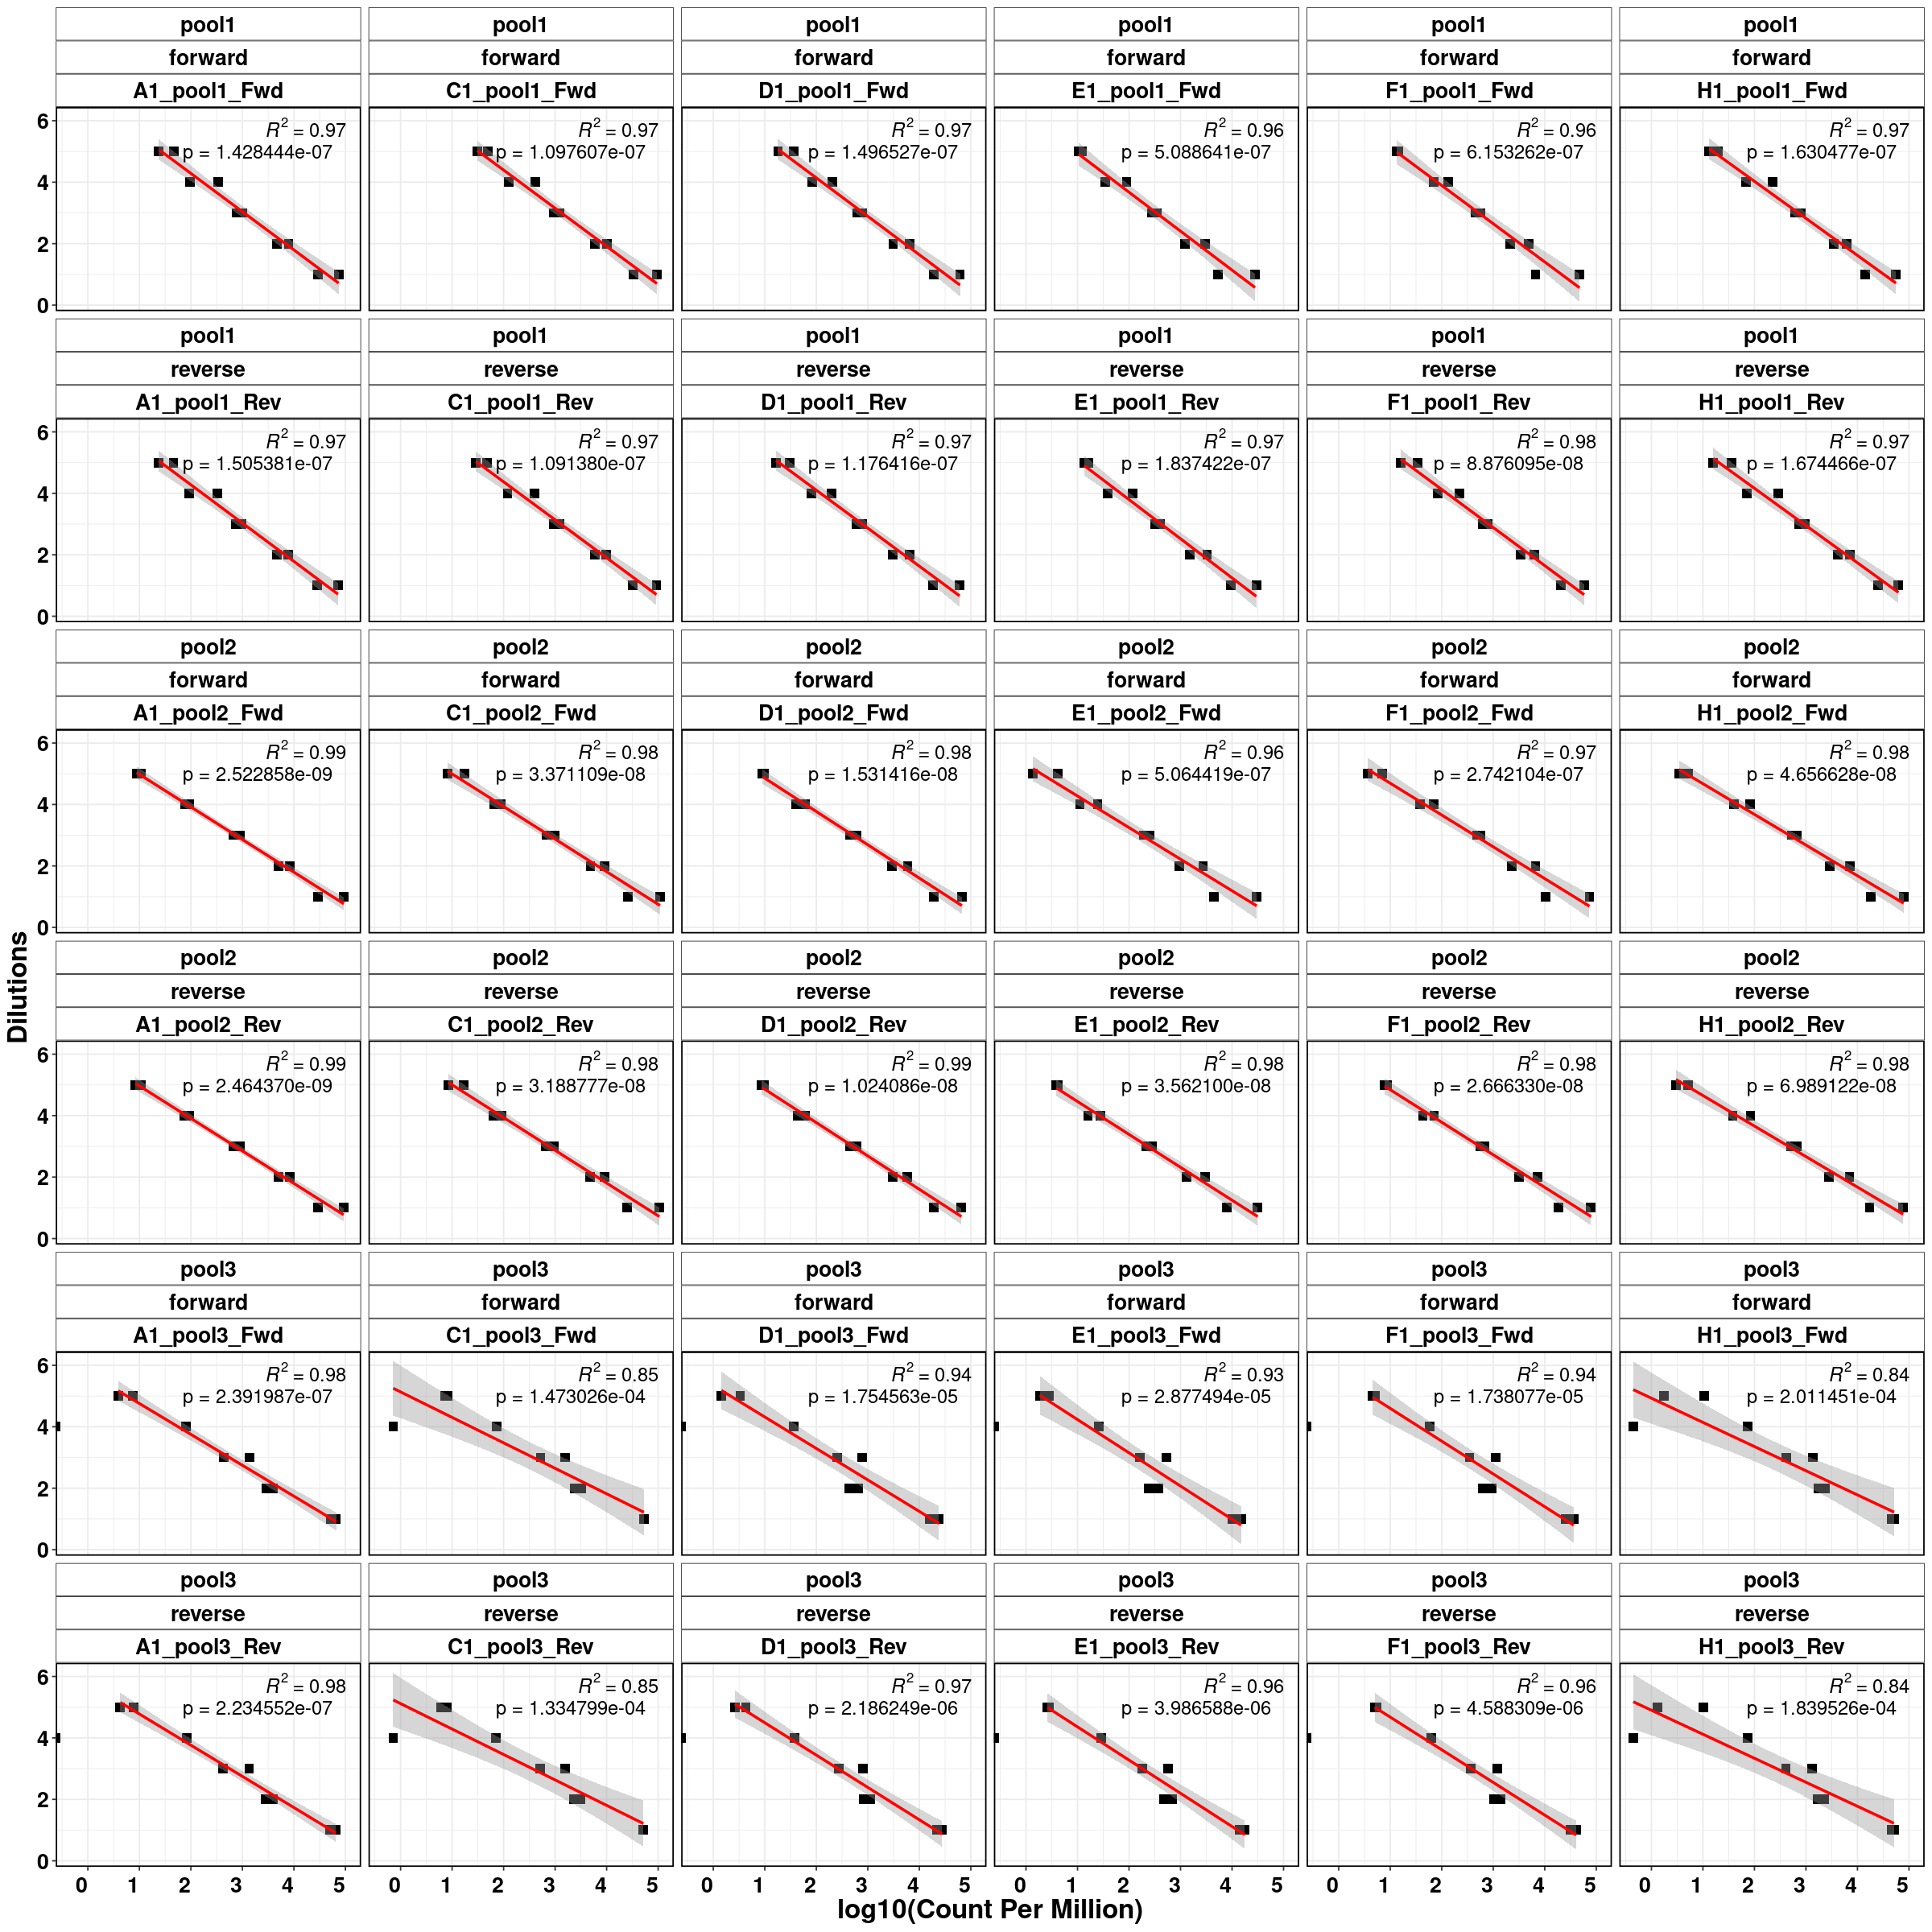

In [10]:
options(repr.plot.width=20, repr.plot.height=20)

ggplot(synDNAMetaAgM, aes(CPMlog, Dilution2)) +
  geom_point(shape = 15, size = 3) +
  #geom_errorbar(aes(xmin=CPMMeanlog-CPMSdlog, xmax=CPMMeanlog+CPMSdlog), width=.3,position=position_dodge(0.05)) +
  facet_wrap(~ Pool+Strand+ID, ncol = 6) +
  geom_smooth(method = "lm", color="red", formula = y ~ x) +
  stat_poly_eq(formula = y ~ x, aes(label = ..rr.label..), 
               parse=TRUE, label.x.npc = "right",, size = 5) +
  stat_fit_glance(method = 'lm', geom = 'text', aes(label = paste0('p = ', format(..p.value.., 3))), 
                  label.x = 3.3, label.y = 5, size = 5) + 
  labs(y = "Dilutions", x = "log10(Count Per Million)") +
  guides(colour = guide_legend(override.aes = list(size=5))) +
  theme_bw() + guides(fill=guide_legend(ncol=1))  +
  theme(panel.border = element_rect(colour = "black", fill=NA, size=1),
        axis.text.x = element_text(angle = 0, hjust = 1, vjust = 0.5, size = 16, face = "bold", colour = "black"),
        axis.text.y = element_text(angle = 0, size = 16, face = "bold", colour = "black"),
        axis.title=element_text(size=20, face = "bold", colour = "black"),
        strip.text.x = element_text(size = 16, face = "bold", colour = "black"),
        strip.background = element_rect(fill="white"),
        legend.title=element_blank())

In [11]:
## Adjusting the libraries dilution. SynDNA pool follow the ratio 1:20.

DilutionLog <- synDNAMetaAgM$Dilution2
DilutionLog[which(DilutionLog == 1)] <- 1/20
DilutionLog[which(DilutionLog == 2)] <- 0.1/20
DilutionLog[which(DilutionLog == 3)] <- 0.01/20
DilutionLog[which(DilutionLog == 4)] <- 0.001/20
DilutionLog[which(DilutionLog == 5)] <- 0.0001/20

synDNAMetaAgM$DilutionLog <- DilutionLog

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing non-finite values (stat_poly_eq).”
Warning message:
“Removed 8 rows containing non-finite values (stat_fit_glance).”


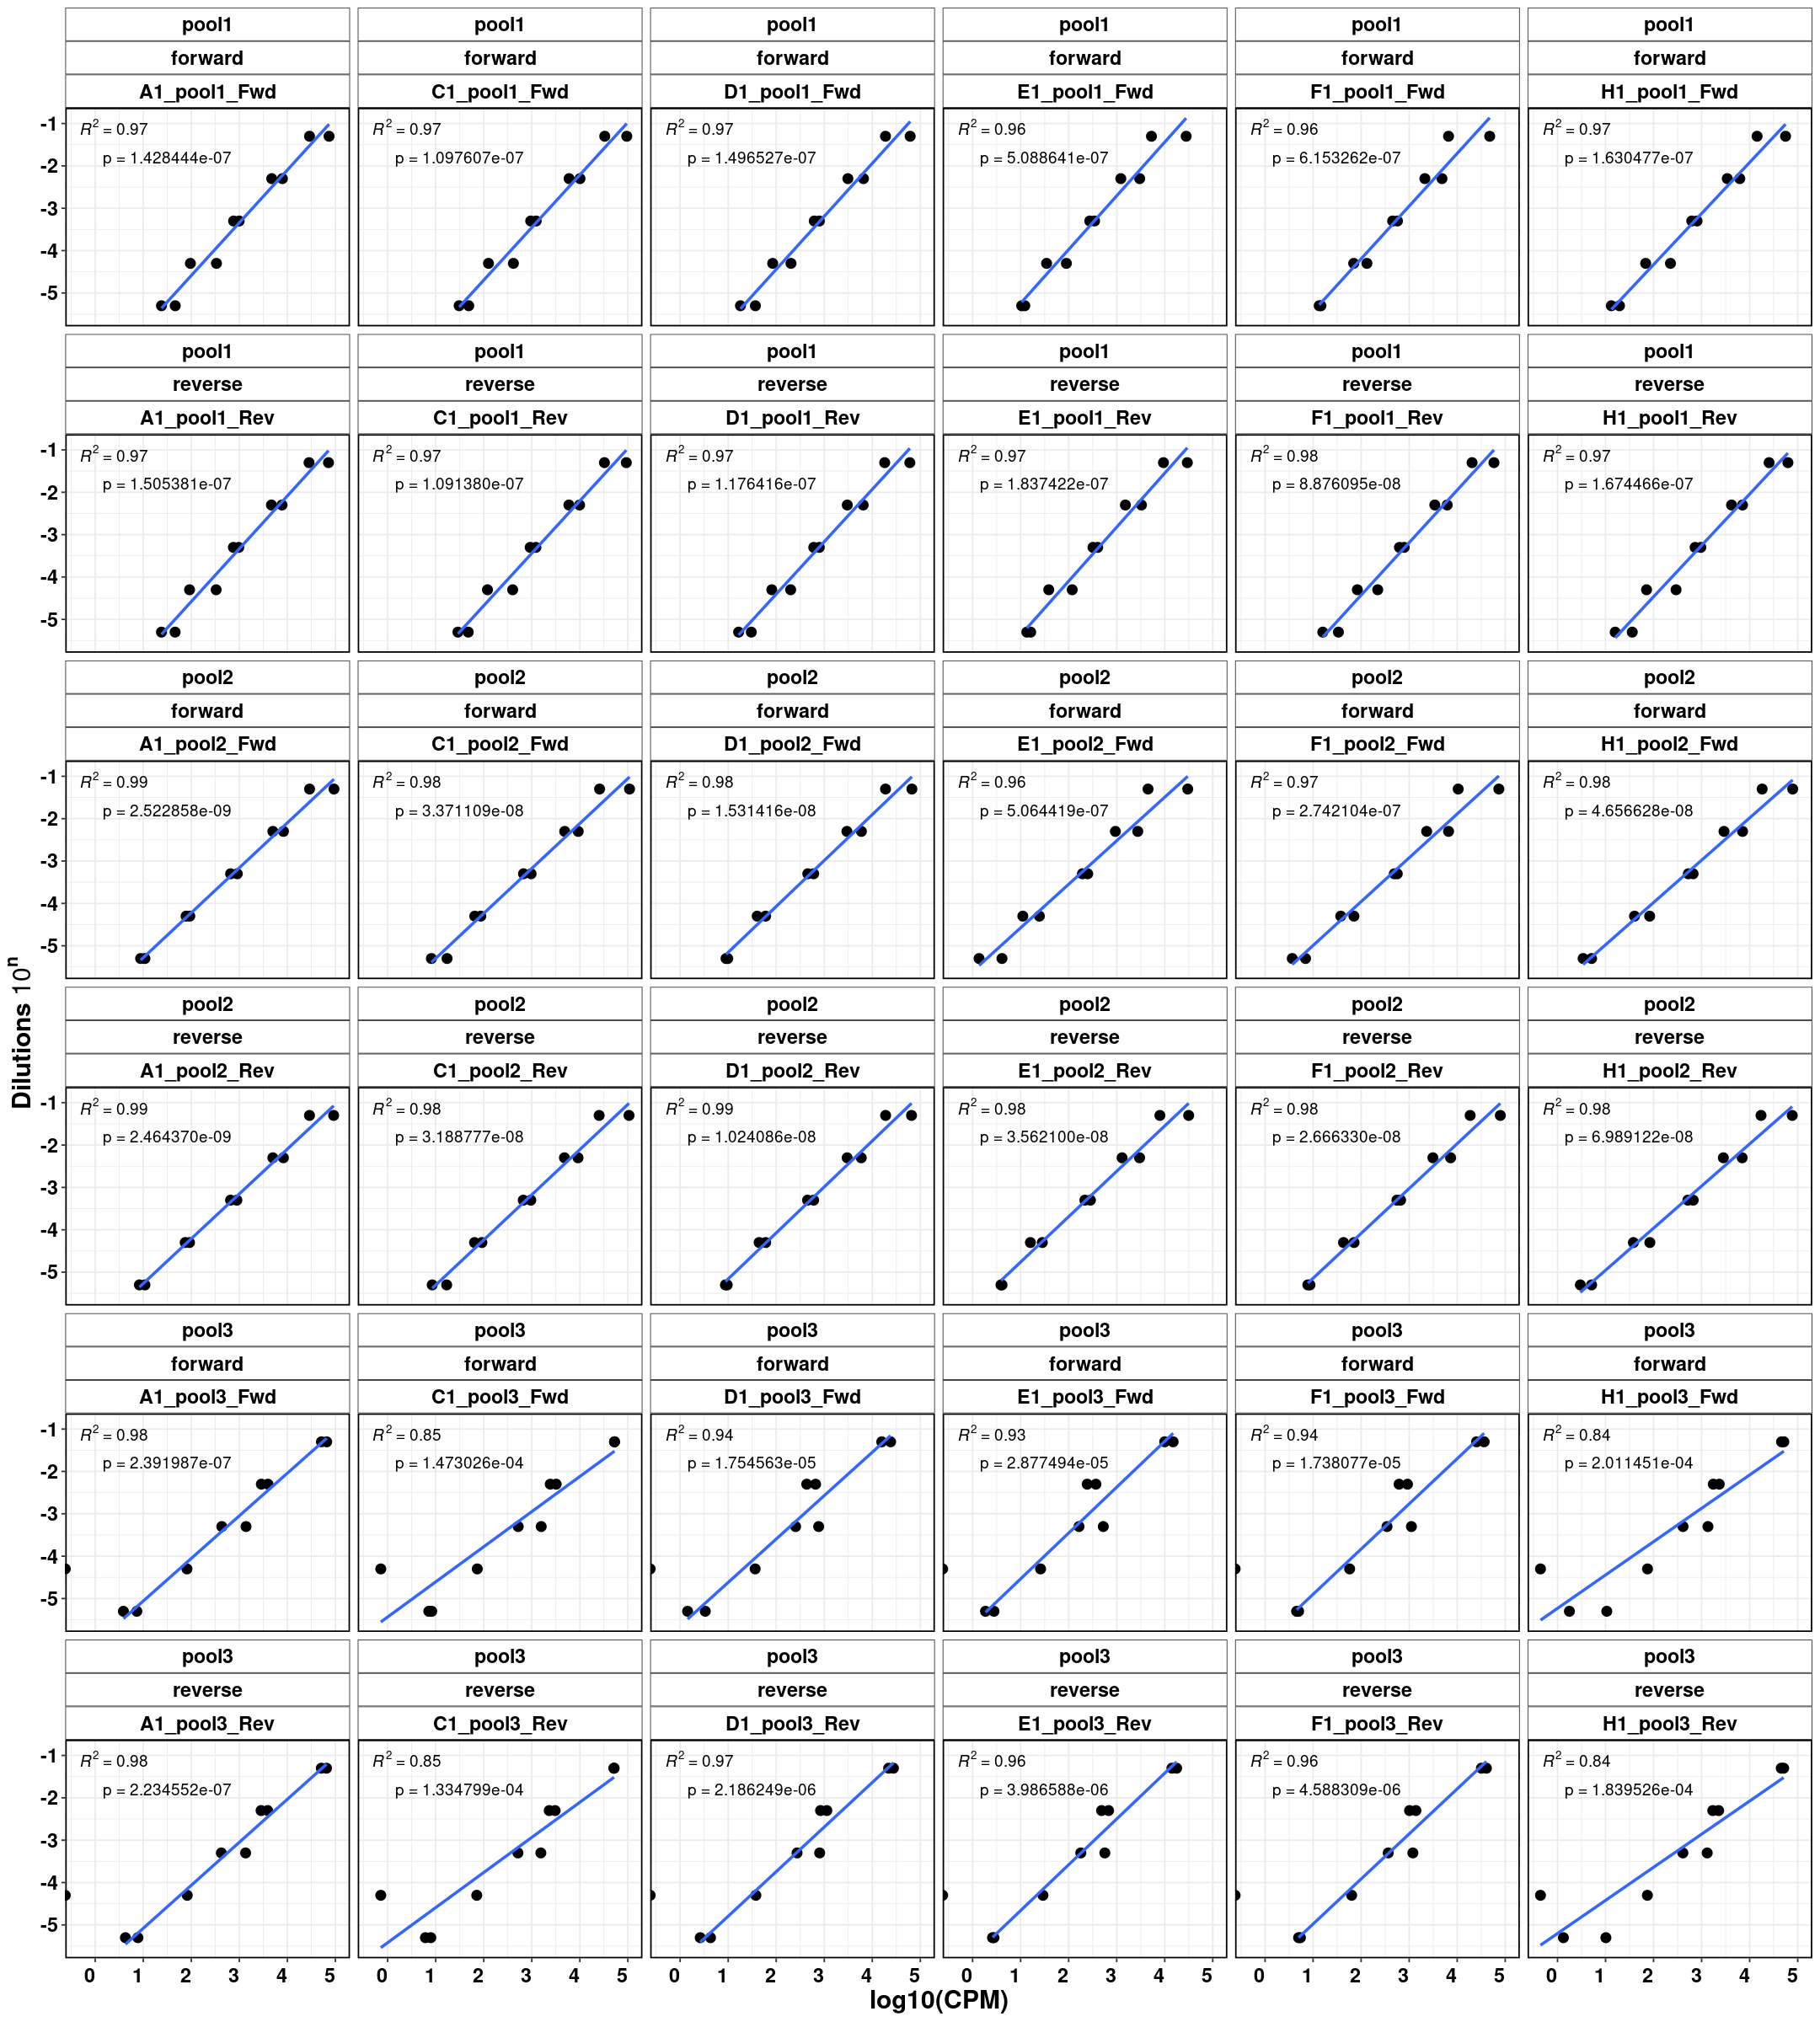

In [12]:
options(repr.plot.width=18, repr.plot.height=20)


ggplot(synDNAMetaAgM, aes(CPMlog, log10((DilutionLog)))) +
  geom_point(size = 3) +
  #geom_errorbar(aes(xmin=log10(CPMMean)-log10(CPMStd), xmax=log10(CPMMean)+log10(CPMStd)), 
  #                  width=.3,position=position_dodge(0.05)) +
  facet_wrap(~ Pool+Strand+ID, ncol = 6) +
  geom_smooth(method = "lm", formula = y ~ x, se=FALSE) +
  stat_poly_eq(formula = y ~ x, aes(label = ..rr.label..), 
               parse=TRUE, label.x.npc = "left", size = 4) +
  stat_fit_glance(method = 'lm', geom = 'text', aes(label = paste0('p = ', format(..p.value.., 3))), 
                  label.x = 1.5, label.y = -1.8, size = 4) + 
  labs(y = expression(bold(paste("Dilutions ", 10^"n"))), x = "log10(CPM)") +  
  guides(colour = guide_legend(override.aes = list(size=5))) +
  theme_bw() + guides(fill=guide_legend(ncol=1))  +
  theme(panel.border = element_rect(colour = "black", fill=NA, size=1),
        axis.text.x = element_text(angle = 0, hjust = 1, vjust = 0.5, size = 14, face = "bold", colour = "black"),
        axis.text.y = element_text(angle = 0, size = 14, face = "bold", colour = "black"),
        axis.title=element_text(size=18, face = "bold", colour = "black"),
        strip.text.x = element_text(size = 14, face = "bold", colour = "black"),
        strip.background = element_rect(fill="white"),
        legend.title=element_blank())

#### Generating the linear models

In [13]:
v1 <- unique(synDNAMetaAgM$Pool)
v2 <- unique(synDNAMetaAgM$Strand)
v3 <- unique(synDNAMetaAgM$ID)
v1v2v3 <- expand.grid(v1,v2,v3)

combinations <- v1v2v3[!duplicated(v1v2v3),]
sel <- c(intersect(grep("pool1", combinations$Var1), grep("pool1", combinations$Var3)),
         intersect(grep("pool2", combinations$Var1), grep("pool2", combinations$Var3)),
         intersect(grep("pool3", combinations$Var1), grep("pool3", combinations$Var3)))

combinations <- combinations[sel,]
colnames(combinations) <- c("Pool", "Strand", "ID")

In [15]:
coefall <- NULL

for(i in 1:dim(combinations)[1]){
    criteria <- as.vector(unlist(combinations[i,]))
    temp <- subset(synDNAMetaAgM, Pool %in% criteria & ID %in% criteria)
    temp <- temp[!(temp$Counts == 0), ]
    lmtemp <- lm(temp$Dilution2~temp$CPMlog)
    coef <- c(criteria, lmtemp$coefficients[1], lmtemp$coefficients[2])
    coefall <- rbind(coefall, coef)
}

colnames(coefall) <- c("Pool", "Strand", "ID", "a_intercept", "b_slope")
rownames(coefall) <- NULL

In [16]:
coefall <- as.data.frame(coefall)
coefall$Strd <- gsub(".*_", "", coefall$ID)
coefall <- coefall[-which(coefall$Strand == "reverse" & coefall$Strd == "Fwd"),]
coefall <- coefall[-which(coefall$Strand == "forward" & coefall$Strd == "Rev"),]

In [18]:
write.table(coefall, "saliva_linear_models.txt", quote = F, row.names = F, sep="\t")